In [1]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
import pandas as pd
import re 

import var as var

In [2]:
def setIDH(dataFrame):

    dataFrameINEP = pd.read_csv(f'./result/INEP.csv')
    idhm = pd.read_csv(f'./data/ibge/idh/data.csv', sep=';')
    idhm['Município'] = idhm['Município'].apply(lambda x: re.sub(r'\s\(\w+\)', '', x))
    validIdhm = idhm[idhm['Município'].isin(dataFrameINEP['NO_MUNICIPIO'].unique())]

    for nomeMunicipio in dataFrame['NO_MUNICIPIO'].unique().tolist():
        idhmMunicipio = validIdhm[validIdhm['Município'] == nomeMunicipio]

        if len(idhmMunicipio) == 0:
            continue

        dataFrame.loc[dataFrame['NO_MUNICIPIO'] == nomeMunicipio, 'IDHM'] = idhmMunicipio['IDHM 2010'].values[0]
    
    dataFrame['IDHM'].fillna(0, inplace=True)

    for nome in dataFrame.loc[dataFrame['IDHM'] == 0,'NO_MUNICIPIO']:
        if nome == 'Pontes e Lacerda':
            nomeBusca = 'Pontes E Lacerda'
        else:
            nomeBusca = nome
        dataFrame.loc[dataFrame['NO_MUNICIPIO'] == nome, 'IDHM'] = idhm.loc[idhm['Município'] == nomeBusca, 'IDHM 2010'].values[0]

    return dataFrame

def groupByYear(dataFrame):
    dataFrameBackup = dataFrame
    dataFrame = dataFrame.groupby(['NO_MUNICIPIO', 'CO_MUNICIPIO']).sum().reset_index()

    for col in var.IBGE_COLUMNS:
        for codMunicipio in dataFrame['CO_MUNICIPIO'].unique().tolist():
            
            for cdIes in dataFrameBackup.loc[dataFrameBackup['CO_MUNICIPIO'] == codMunicipio, 'CO_IES'].unique().tolist():
                dataFrame.loc[dataFrame['CO_MUNICIPIO'] == codMunicipio, col] = dataFrameBackup.loc[(dataFrameBackup['CO_MUNICIPIO'] == codMunicipio) & (dataFrameBackup['CO_IES'] == cdIes), col].sum()
                break

    return dataFrame

def groupByNameAndYear(dataFrame):
    return dataFrame[['ANO', 'NO_MUNICIPIO', 'CO_MUNICIPIO'] + var.IBGE_COLUMNS + var.INEP_COLUMNS].groupby(['ANO', 'NO_MUNICIPIO', 'CO_MUNICIPIO'] + var.IBGE_COLUMNS).sum().reset_index()

divisor = 0
notValidCols = ['2009', '2010', '2020']

def formatar_rotulos(valor, e):
    return '{:.0f}'.format(valor / divisor)

# Função para substituir vírgulas por pontos e converter para float
def substituir_virgula(valor):
    return valor.replace(',', '.')

def formatar_rotulos(valor, e):
    return '{:.0f} B'.format(valor / divisor)
    
def makeIDH(dataFrame):

    idhm = pd.read_csv(f'./data/ibge/idh/data.csv', sep=';')
    idhm['Município'] = idhm['Município'].apply(lambda x: re.sub(r'\s\(\w+\)', '', x))
    
    idhm['IDHM 2010'] = idhm['IDHM 2010'].astype(str)
    idhm['IDHM 2010'] = idhm['IDHM 2010'].apply(lambda x: substituir_virgula(x))
    idhm['IDHM 2010'] = idhm['IDHM 2010'].astype(float)

    fig = plt.figure(figsize=(8, 5))
    
    sns.boxplot(data=[idhm['IDHM 2010'].values.tolist()] + [dataFrame['IDHM'].values.tolist()], palette=['red', 'blue'])
    plt.xticks(range(2), ['Conjunto\ntotal', 'Conjunto de\ncomputação'])
    
    plt.ylabel('IDH')
    plt.savefig('./result/IBGE_IDH.png')

def generateVisualization(dataFrame, pib=False, pop=False, idh=False):

    if (pib and pop and idh) or (not pib and not pop and not idh):
        print('Erro!')
        return
    
    dicTotal = {}
    dicComputacao = {}

    if pop:
        label = 'População'
        column = 'IBGE_MUNICIPIO_POP'
        chartLabel = 'População (Milhões)'
        dataTotal = pd.read_csv(f'./data/ibge/populacao/data.csv', sep=';')
    elif pib:
        label = 'PIB'
        column = 'IBGE_MUNICIPIO_PIB'
        chartLabel = 'PIB (Bilhões)'
        dataTotal = pd.read_csv(f'./data/ibge/pib/data.csv', sep=';')
    elif idh:
        makeIDH(dataFrame)
        return
    
    display(dataTotal)
    
    tot = 0
    print(f'>> {label} total:')

    for col in dataTotal.columns:
        
        if col != 'Cód.' and col != 'Município' and col not in notValidCols:
            dataTotal.loc[dataTotal[col] == '...', col] = 0

            if pop:
                dataTotal[col] = dataTotal[col].astype(int)
            elif pib:
                dataTotal[col] = dataTotal[col].astype(str)
                dataTotal[col] = dataTotal[col].apply(lambda x: substituir_virgula(x))
                dataTotal[col] = dataTotal[col].astype(float)

            dicTotal[col] = dataTotal[col].sum()
            tot += dataTotal[col].sum()
            print('{}: {}'.format(col, dataTotal[col].sum()))

    print('>> Total: {}\n\n'.format(tot))

    tot2 = 0
    print('>> População computação:')
    for ano in dataFrame['ANO'].unique():
        if str(ano) in notValidCols:
            continue

        dataAno = dataFrame[dataFrame['ANO'] == ano]
        dicComputacao[str(ano)] = dataAno[column].sum()
        tot2 += dataAno[column].sum()
        print('{}: {}'.format(ano, dataAno[column].sum()))

    print('>> Total: {}\n\n'.format(tot2))

    pct = []
    for ano in dicTotal.keys():
        conta = round((dicComputacao[ano]*100) / dicTotal[ano], 1)
        pct.append(str(conta) + ' %')
        print('{}:\n>>> porcentagem de computação: {}%'.format(ano, conta))

    print('\n>>> porcentagem TOTAL de computação: {}%\n\n'.format(round((tot2*100) / tot, 2)))

    # Definindo as cores para cada par de valores
    cores = ['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red']
    cores2 = ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']

    fig = plt.figure(figsize=(8, 5))

    # Configurando o gráfico de barras
    plt.bar(dicComputacao.keys(), dicTotal.values(), color=cores, label='Total')
    plt.bar(dicComputacao.keys(), dicComputacao.values(), color=cores2, label='Computação')

    # Aplicando o formatador de rótulos ao eixo y
    if pop:
        divisor = 1000000
    elif pib:
        divisor = 1000000000

    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(formatar_rotulos))

    # Adicionando legendas e rótulos
    plt.xlabel('Ano', size=12)
    plt.ylabel(chartLabel, size=12)

    annotateValues = [
        [-0.37, '2011'],
        [0.63, '2012'],
        [1.63, '2013'],
        [2.63, '2014'],
        [3.63, '2015'],
        [4.63, '2016'],
        [5.63, '2017'],
        [6.63, '2018'],
        [7.63, '2019'],
    ]

    for i, value in enumerate(annotateValues):
        plt.annotate(pct[i], (value[0], dicComputacao[value[1]]/2), color='white', size=10)

    plt.savefig(f'./result/IBGE_{label.upper()}.png')
    plt.show()
    

In [3]:
dataFrameIBGE = pd.read_csv(f'./result/IBGE.csv')

# agrupamento pelo ano
dataFrameYear = groupByYear(dataFrameIBGE)
dataFrameYearIDH = setIDH(dataFrameYear)

# agrupamento pelo municipio e ano
dataFrameYearName = groupByNameAndYear(dataFrameIBGE)

C:\Users\aliss\AppData\Local\Temp\ipykernel_16500\2444221429.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dataFrame = dataFrame.groupby(['NO_MUNICIPIO', 'CO_MUNICIPIO']).sum().reset_index()


,Cód.,Município,2009,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,1100015,Alta Floresta D'Oeste (RO),24354,24228,24069,25728,25652,25578,25506,25437,23167,22945,22728
1,1100023,Ariquemes (RO),85541,91570,92747,101269,102860,104401,105896,107345,106168,107863,109523
2,1100031,Cabixi (RO),6695,6221,6132,6495,6424,6355,6289,6224,5438,5312,5188
3,1100049,Cacoal (RO),78675,78959,79330,85863,86556,87226,87877,88507,84813,85359,85893
4,1100056,Cerejeiras (RO),16622,16939,16852,18041,18013,17986,17959,17934,16444,16323,16204
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,5222005,Vianópolis (GO),12831,12644,12737,13227,13343,13456,13567,13675,13746,13863,13977
5566,5222054,Vicentinópolis (GO),6093,7476,7576,7933,8053,8171,8286,8397,8611,8743,8873
5567,5222203,Vila Boa (GO),4578,4847,4954,5246,5371,5495,5615,5731,6026,6171,6312
5568,5222302,Vila Propício (GO),5359,5196,5244,5460,5520,5578,5635,5690,5758,5821,5882


>> População total:
2011: 192379287
2012: 193946886
2013: 201032714
2014: 202768562
2015: 204450049
2016: 206081432
2017: 207660929
2018: 208494900
2019: 210147125
>> Total: 1826961884


>> População computação:
2011: 77158151
2012: 79036146
2013: 82275230
2014: 83921649
2015: 84666533
2016: 85043675
2017: 85842669
2018: 85825381
2019: 86536336
>> Total: 750305770


2011:
>>> porcentagem de computação: 40.1%
2012:
>>> porcentagem de computação: 40.8%
2013:
>>> porcentagem de computação: 40.9%
2014:
>>> porcentagem de computação: 41.4%
2015:
>>> porcentagem de computação: 41.4%
2016:
>>> porcentagem de computação: 41.3%
2017:
>>> porcentagem de computação: 41.3%
2018:
>>> porcentagem de computação: 41.2%
2019:
>>> porcentagem de computação: 41.2%

>>> porcentagem TOTAL de computação: 41.07%




C:\Users\aliss\AppData\Local\Temp\ipykernel_16500\2444221429.py:54: RuntimeWarning: invalid value encountered in scalar divide
  return '{:.0f} B'.format(valor / divisor)
C:\Users\aliss\AppData\Local\Temp\ipykernel_16500\2444221429.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  return '{:.0f} B'.format(valor / divisor)


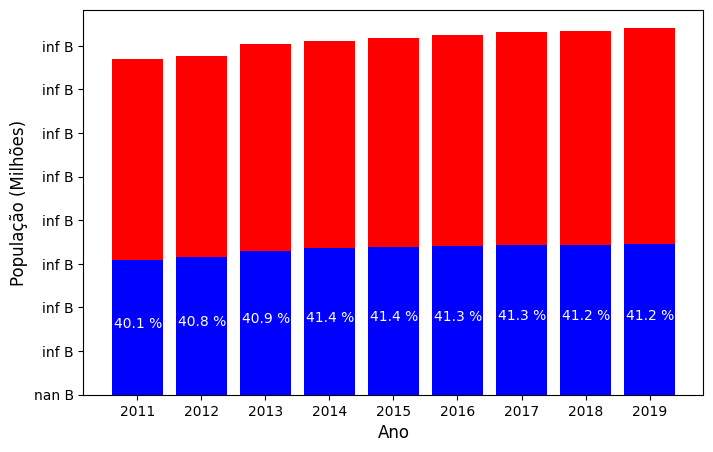

In [4]:
generateVisualization(dataFrameYearName, pop=True)

,Cód.,Município,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,1100015,Alta Floresta D'Oeste (RO),"256986,138","262076,878","280509,583","329029,479","341324,694",377799,"421299,976","478216,984","485374,332","498980,128","495628,767"
1,1100023,Ariquemes (RO),"1133094,861","1364693,78","1651885,023","1703641,937","1799852,506","1921531,616","2037798,613","2184346,102","2287910,379","2464704,105","2578829,725"
2,1100031,Cabixi (RO),"69776,003","69611,114","77217,187","99586,481","96364,539","113477,403","116565,18","133342,248","138109,964","140503,211","139959,39"
3,1100049,Cacoal (RO),"985478,839","1186494,091","1259024,293","1372705,085","1433253,506","1660649,611","1794477,511","1947282,542","2082761,125","2175839,894","2260643,565"
4,1100056,Cerejeiras (RO),"190902,128","222021,189","260142,097","357332,997","353269,678","392416,835","397736,132","408193,827","439245,42","470647,262","506854,457"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,5222005,Vianópolis (GO),"164336,337","178699,423","223143,533","255872,599","291918,737","302880,371","312347,898","373802,147","395861,114","449973,321","483663,323"
5566,5222054,Vicentinópolis (GO),"133430,413","133899,367","149229,71","224412,203","259421,576","275800,237","322298,361","351750,24","350838,524","339088,609","342355,634"
5567,5222203,Vila Boa (GO),"73367,381","71675,769","84103,148","88464,936","103233,39","90478,092","111228,928","138809,507","118638,961","108469,397","113668,466"
5568,5222302,Vila Propício (GO),"107125,391","92062,861","112820,822","140347,852","142969,639","138474,215","198935,241","210475,085","182202,882","179914,583","206971,225"


>> PIB total:
2011: 4376382000.077
2012: 4814760000.078
2013: 5331618956.589001
2014: 5778952780.06
2015: 5995787000.013
2016: 6269327999.980001
2017: 6585479000.013999
2018: 7004141000.012
2019: 7389131000.059
>> Total: 53545579736.882


>> População computação:
2011: 2481569656.368
2012: 2741661901.2710004
2013: 3002694441.994
2014: 3236967707.9989996
2015: 3330299239.17
2016: 3444017123.589999
2017: 3574793301.533
2018: 3764360228.9990005
2019: 3941749980.6629996
>> Total: 29518113581.586998


2011:
>>> porcentagem de computação: 56.7%
2012:
>>> porcentagem de computação: 56.9%
2013:
>>> porcentagem de computação: 56.3%
2014:
>>> porcentagem de computação: 56.0%
2015:
>>> porcentagem de computação: 55.5%
2016:
>>> porcentagem de computação: 54.9%
2017:
>>> porcentagem de computação: 54.3%
2018:
>>> porcentagem de computação: 53.7%
2019:
>>> porcentagem de computação: 53.3%

>>> porcentagem TOTAL de computação: 55.13%




C:\Users\aliss\AppData\Local\Temp\ipykernel_16500\2444221429.py:54: RuntimeWarning: invalid value encountered in scalar divide
  return '{:.0f} B'.format(valor / divisor)
C:\Users\aliss\AppData\Local\Temp\ipykernel_16500\2444221429.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  return '{:.0f} B'.format(valor / divisor)


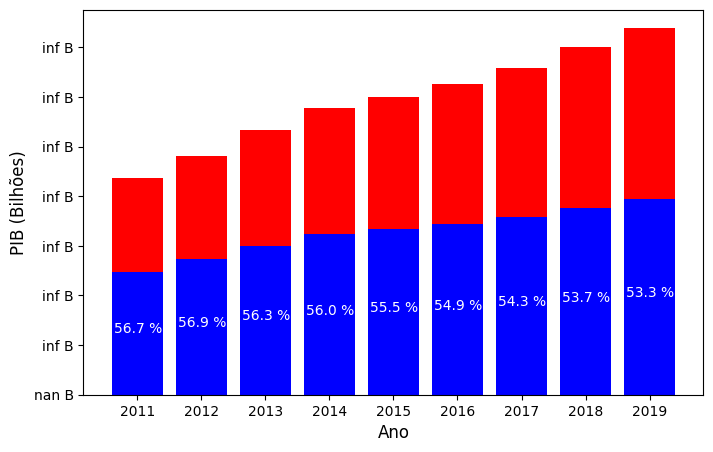

In [5]:
generateVisualization(dataFrameYearName, pib=True)

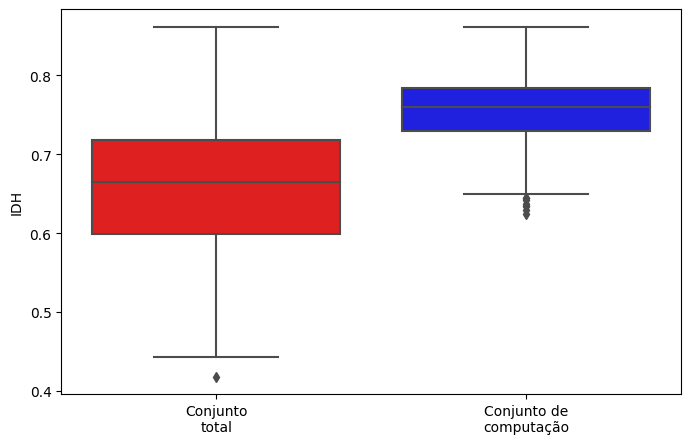

In [6]:
generateVisualization(dataFrameYearIDH, idh=True)